In [2]:
from __future__ import division
import os
import numpy as np
import PIL.Image as pil
import tensorflow as tf
from SfMLearner import SfMLearner
from utils import normalize_depth_for_display

img_height=128
img_width=416
ckpt_file = 'models/model-190532'
I = pil.open('misc/msample.png', 'r')
I = I.resize((img_width, img_height), pil.ANTIALIAS)
I = np.array(I)

In [3]:
sfm = SfMLearner()
sfm.setup_inference(img_height,
                    img_width,
                    mode='depth')

In [4]:
saver = tf.train.Saver([var for var in tf.model_variables()]) 
with tf.Session() as sess:
    saver.restore(sess, ckpt_file)
    pred = sfm.inference(I[None,:,:,:], sess, mode='depth')

INFO:tensorflow:Restoring parameters from models/model-190532


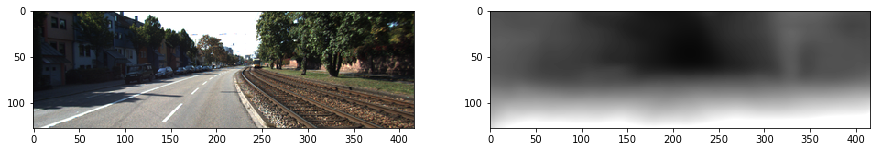

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(I)
plt.subplot(1,2,2); plt.imshow(normalize_depth_for_display(pred['depth'][0,:,:,0]))

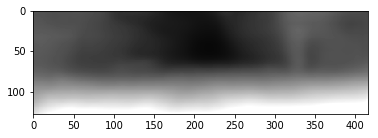

In [6]:
import matplotlib.pyplot as plt
depth_map = pred['depth'][0,:,:,0]
normalize_depth = normalize_depth_for_display(pred['depth'][0,:,:,0])

plt.figure()
plt.imshow(normalize_depth)
plt.show()

In [7]:
def read_raw_calib_file(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                    data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                    pass
    return data

In [8]:
calib_data = read_raw_calib_file("misc/calib_cam_to_cam.txt")
P_rect = np.reshape(calib_data['P_rect_' + '00'], (3, 4))
intrinsics = P_rect[:3, :3]
print(intrinsics)

[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]


In [11]:
from math import degrees, acos
from depthImgProcessor import processDepthImage
def getHHAImg(depthImage, missingMask,cameraMatrix):
    pc, N, yDir, h, R = processDepthImage(depthImage * 100, missingMask, cameraMatrix)

    tmp = np.multiply(N, yDir)
    # with np.errstate(invalid='ignore'):
    acosValue = np.minimum(1,np.maximum(-1,np.sum(tmp, axis=2)))
    angle = np.array([degrees(acos(x)) for x in acosValue.flatten()])
    angle = np.reshape(angle, h.shape)

    pc[:,:,2] = np.maximum(pc[:,:,2], 100)
    I = np.zeros(pc.shape)
    I[:,:,0] = 31000/pc[:,:,2]
    I[:,:,1] = h
    I[:,:,2] = (angle + 128-90)
    HHA = I.astype(np.uint8)
    return HHA

In [12]:
depth = pred['depth'][0,:,:,0] * 100
missingMsk = np.zeros(depth.shape)
HHA = getHHAImg(depth, missingMsk, intrinsics)
# pc, N, yDir, h, R = processDepthImage(depth, missingMsk, intrinsics)

In [14]:
height_map = HHA[:,:,1]

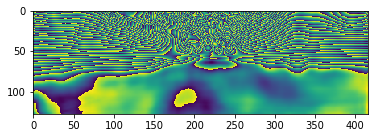

In [15]:
plt.figure()
plt.imshow(height_map)
plt.show()